In [18]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Setup

In [27]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108
# train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-9, store_filters=True, epsilon=3e-15)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

No GPU available! Running on CPU


In [28]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi1D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
            
            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi1D(recon, X)
                v, T = awi1D.filters[0], awi1D.T

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())


                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)#, figsize=(15,15))
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].plot(v.detach().cpu().numpy())
                axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                axs[1, 0].set_title("T-1D vs v-1D")
                axs[1, 0].set_ylim(None, 1.1)

                axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
                axs[1, 1].set_title("T1D - v1D")
                axs[1, 1].set_ylim(None, 1.1)
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss1d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [29]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder FC

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23150771856307983, 'train_awi1d_loss': 11.2908296585083, 'train_kl_loss': 0.0}
 argidx T, v:  783 440


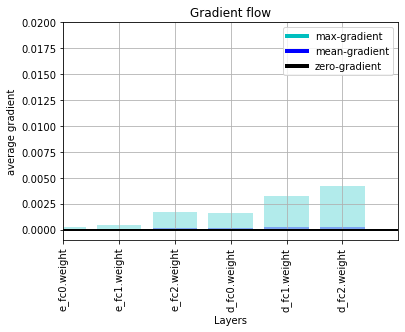

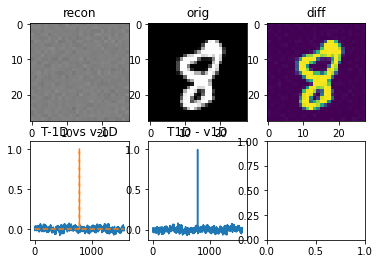

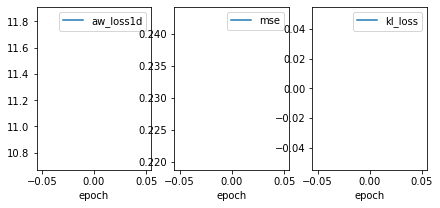

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:46
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:12
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:00
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:54
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:51
  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:38
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:38
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:38
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:37
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:38
 11% (11 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:37
 12% (12 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:36
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23688173294067383, 'train_awi1d_loss': 9.666236877441406, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


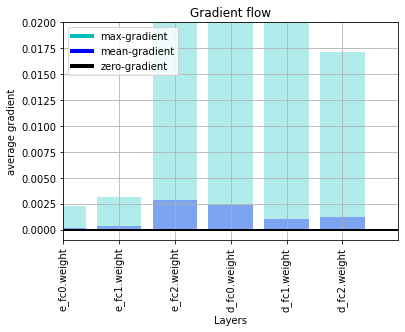

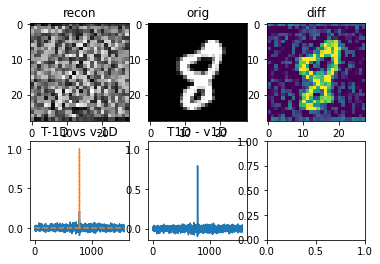

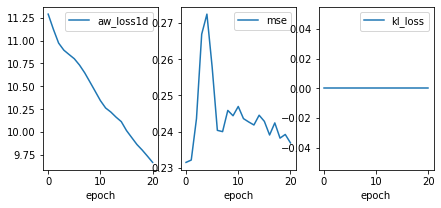

 21% (21 of 100) |####                   | Elapsed Time: 0:00:10 ETA:   0:00:55
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:53
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:52
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:46
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:43
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:12 ETA:   0:00:32
 27% (27 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:31
 28% (28 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:31
 29% (29 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:30
 30% (30 of 100) |######                 | Elapsed Time: 0:00:14 ETA:   0:00:30
 31% (31 of 100) |#######                | Elapsed Time: 0:00:14 ETA:   0:00:30
 32% (32 of 100) |#######                | Elapsed Time: 0:00:15 ETA:   0:00:29
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.22654855251312256, 'train_awi1d_loss': 8.638625144958496, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


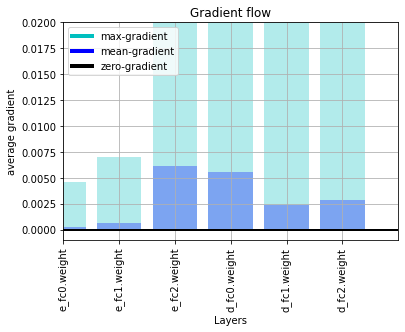

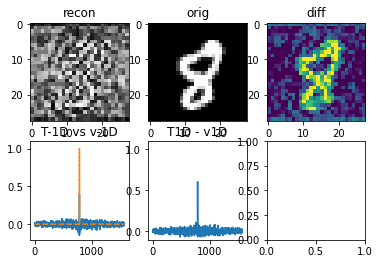

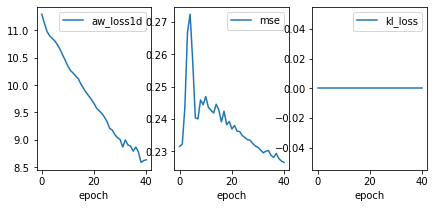

 41% (41 of 100) |#########              | Elapsed Time: 0:00:19 ETA:   0:00:40
 42% (42 of 100) |#########              | Elapsed Time: 0:00:20 ETA:   0:00:38
 43% (43 of 100) |#########              | Elapsed Time: 0:00:20 ETA:   0:00:34
 44% (44 of 100) |##########             | Elapsed Time: 0:00:20 ETA:   0:00:34
 45% (45 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:31
 46% (46 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:23
 47% (47 of 100) |##########             | Elapsed Time: 0:00:22 ETA:   0:00:22
 48% (48 of 100) |###########            | Elapsed Time: 0:00:22 ETA:   0:00:21
 49% (49 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:21
 50% (50 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:21
 51% (51 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:20
 52% (52 of 100) |###########            | Elapsed Time: 0:00:24 ETA:   0:00:20
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.2201753556728363, 'train_awi1d_loss': 7.834505081176758, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


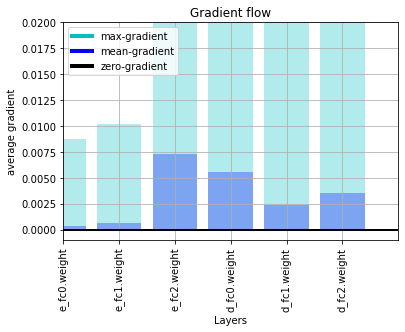

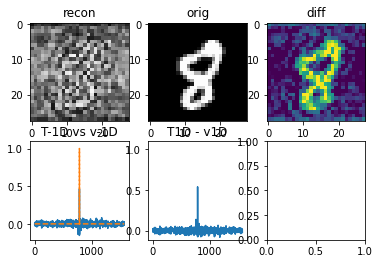

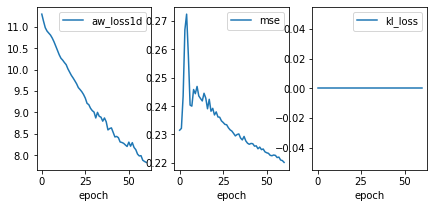

 61% (61 of 100) |##############         | Elapsed Time: 0:00:29 ETA:   0:00:27
 62% (62 of 100) |##############         | Elapsed Time: 0:00:29 ETA:   0:00:27
 63% (63 of 100) |##############         | Elapsed Time: 0:00:30 ETA:   0:00:26
 64% (64 of 100) |##############         | Elapsed Time: 0:00:30 ETA:   0:00:23
 65% (65 of 100) |##############         | Elapsed Time: 0:00:31 ETA:   0:00:21
 66% (66 of 100) |###############        | Elapsed Time: 0:00:31 ETA:   0:00:16
 67% (67 of 100) |###############        | Elapsed Time: 0:00:32 ETA:   0:00:17
 68% (68 of 100) |###############        | Elapsed Time: 0:00:32 ETA:   0:00:17
 69% (69 of 100) |###############        | Elapsed Time: 0:00:33 ETA:   0:00:17
 70% (70 of 100) |################       | Elapsed Time: 0:00:33 ETA:   0:00:16
 71% (71 of 100) |################       | Elapsed Time: 0:00:34 ETA:   0:00:16
 72% (72 of 100) |################       | Elapsed Time: 0:00:35 ETA:   0:00:16
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.21577465534210205, 'train_awi1d_loss': 7.214033126831055, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


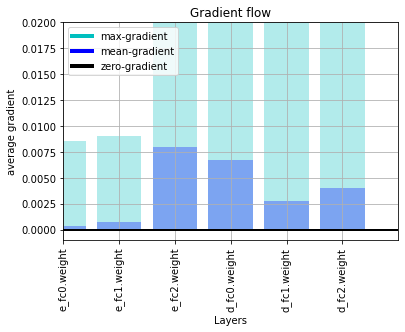

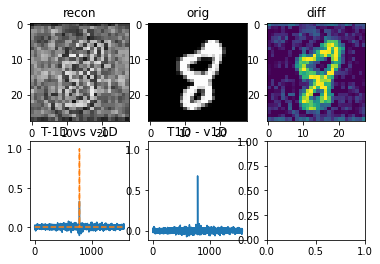

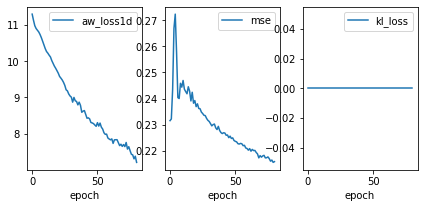

 81% (81 of 100) |##################     | Elapsed Time: 0:00:40 ETA:   0:00:14
 82% (82 of 100) |##################     | Elapsed Time: 0:00:41 ETA:   0:00:13
 83% (83 of 100) |###################    | Elapsed Time: 0:00:41 ETA:   0:00:13
 84% (84 of 100) |###################    | Elapsed Time: 0:00:42 ETA:   0:00:11
 85% (85 of 100) |###################    | Elapsed Time: 0:00:43 ETA:   0:00:08
 86% (86 of 100) |###################    | Elapsed Time: 0:00:43 ETA:   0:00:08
 87% (87 of 100) |####################   | Elapsed Time: 0:00:44 ETA:   0:00:07
 88% (88 of 100) |####################   | Elapsed Time: 0:00:44 ETA:   0:00:07
 89% (89 of 100) |####################   | Elapsed Time: 0:00:45 ETA:   0:00:06
 90% (90 of 100) |####################   | Elapsed Time: 0:00:45 ETA:   0:00:05
 91% (91 of 100) |####################   | Elapsed Time: 0:00:46 ETA:   0:00:05
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:47 ETA:   0:00:04
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.21168771386146545, 'train_awi1d_loss': 7.104474067687988, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


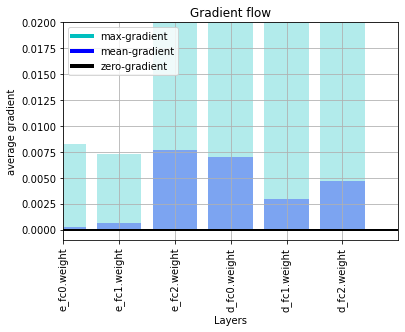

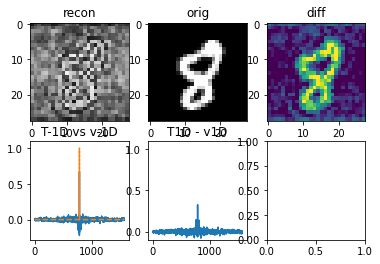

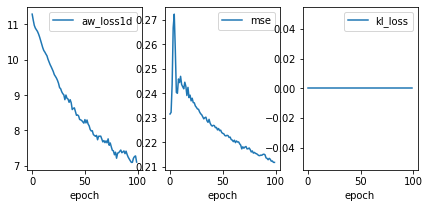

100% (100 of 100) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


In [30]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)



## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


N/A% (0 of 625) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:09
  0% (2 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:08
  0% (4 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:06
  0% (5 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:07
  0% (6 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:06
  1% (7 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:06
  1% (8 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:07
  1% (9 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:06
  1% (10 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:06
  1% (11 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:06
  1% (12 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:06
  2% (13 of 625) |                      

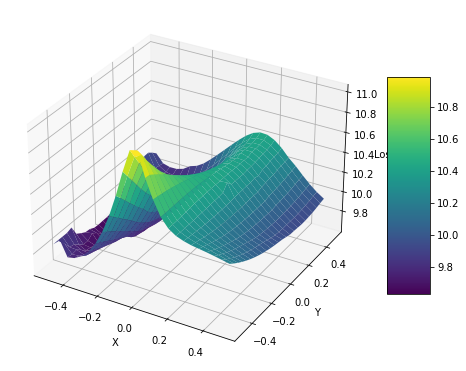

In [32]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23199564218521118, 'train_awi1d_loss': 264.3459167480469, 'train_kl_loss': 521.2367553710938}
 argidx T, v:  783 720


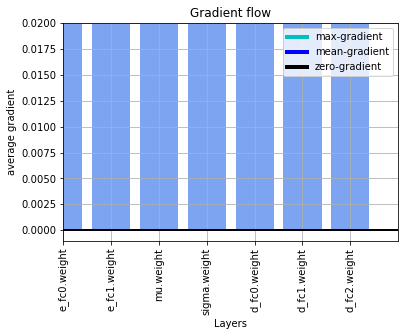

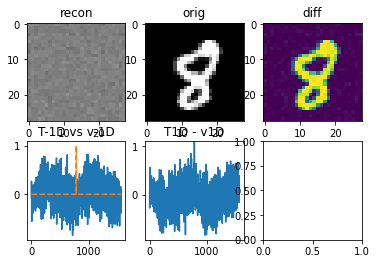

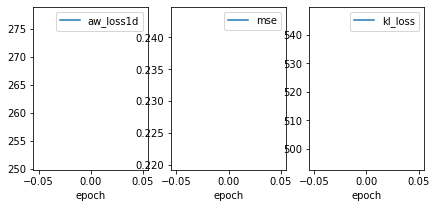

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:37
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:52
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:47
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:44
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:41
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:30
  9% (9 of 100) |##                      | Elapsed Time: 0:00:03 ETA:   0:00:30
 10% (10 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:29
 11% (11 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:29
 12% (12 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:28
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23327085375785828, 'train_awi1d_loss': 161.39352416992188, 'train_kl_loss': 785.0758666992188}
 argidx T, v:  783 1219


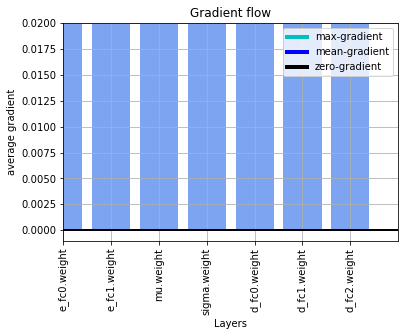

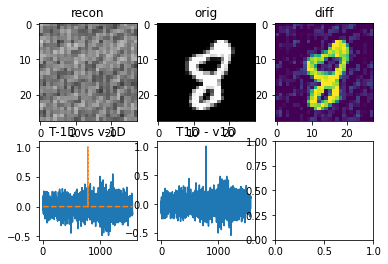

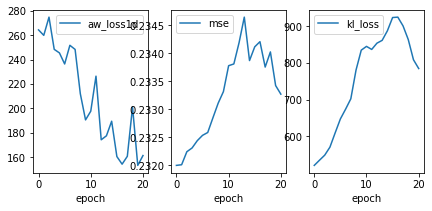

 21% (21 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:39
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:39
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:38
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:35
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:34
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:32
 27% (27 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:31
 28% (28 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:24
 29% (29 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:23
 30% (30 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:23
 31% (31 of 100) |#######                | Elapsed Time: 0:00:11 ETA:   0:00:23
 32% (32 of 100) |#######                | Elapsed Time: 0:00:11 ETA:   0:00:22
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.23494121432304382, 'train_awi1d_loss': 148.4026641845703, 'train_kl_loss': 796.5919799804688}
 argidx T, v:  783 1138


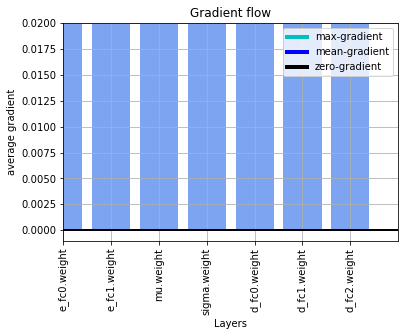

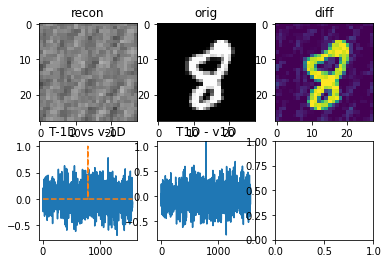

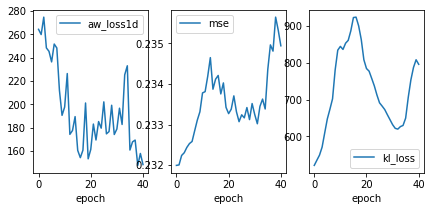

 41% (41 of 100) |#########              | Elapsed Time: 0:00:15 ETA:   0:00:31
 42% (42 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:30
 43% (43 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:29
 44% (44 of 100) |##########             | Elapsed Time: 0:00:16 ETA:   0:00:29
 45% (45 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:26
 46% (46 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:24
 47% (47 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:17
 48% (48 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 49% (49 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 50% (50 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:16
 51% (51 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 52% (52 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.23986345529556274, 'train_awi1d_loss': 143.40695190429688, 'train_kl_loss': 1414.222412109375}
 argidx T, v:  783 521


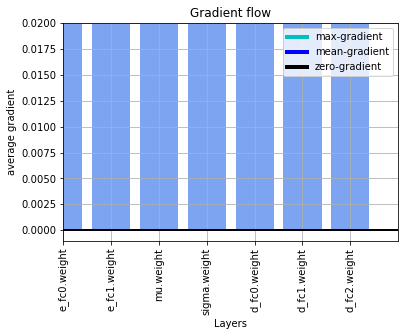

KeyboardInterrupt: 

In [6]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.24488100409507751, 'train_awi1d_loss': 11.276659965515137, 'train_kl_loss': 0.0}
 argidx T, v:  783 601


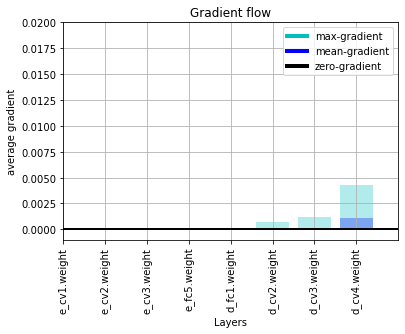

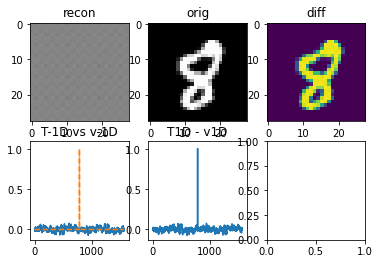

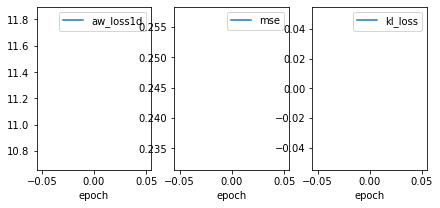

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:44
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:57
  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:35
  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:23
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56
  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:52
  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:52
  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:53
  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:54
 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:52
 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51
 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:49
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.2689383327960968, 'train_awi1d_loss': 10.656468391418457, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


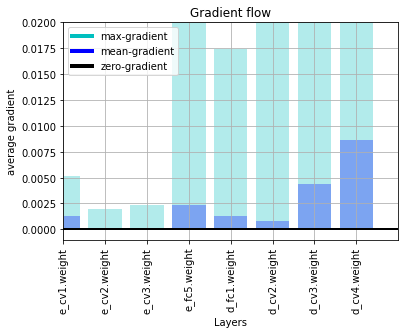

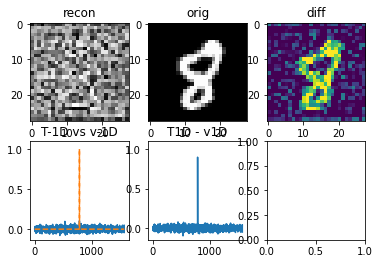

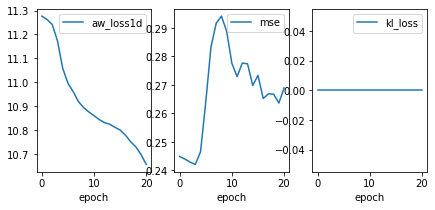

 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:02:23
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:51
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:26
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:17
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:06
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:56
 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50
 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48
 29% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48
 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:52
 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:54
 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:49
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.2529131770133972, 'train_awi1d_loss': 9.880205154418945, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


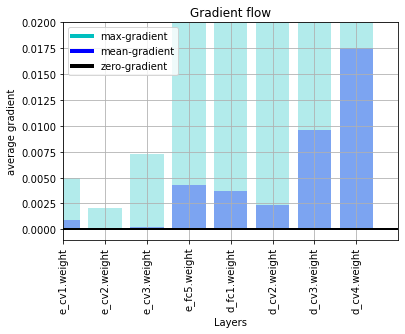

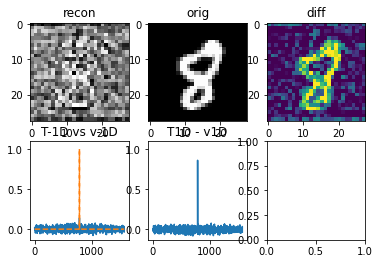

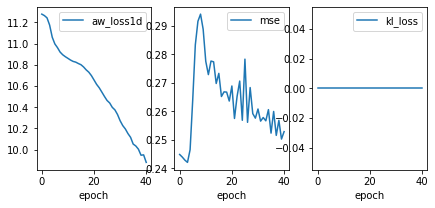

 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:01:12
 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:01:20
 43% (43 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:01:09
 44% (44 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:01:06
 45% (45 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:57
 46% (46 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:51
 47% (47 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:45
 48% (48 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:38
 49% (49 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:41
 50% (50 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:45
 51% (51 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:44
 52% (52 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:45
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.23390616476535797, 'train_awi1d_loss': 9.259647369384766, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


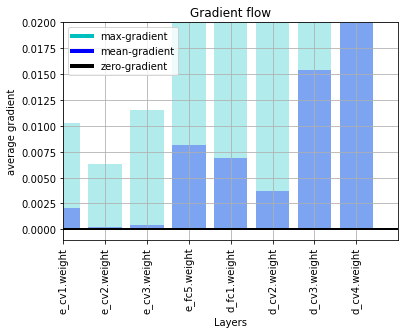

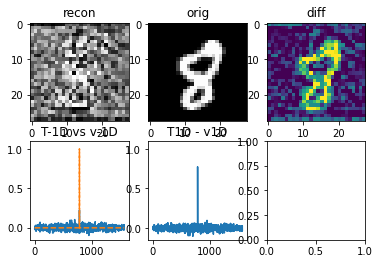

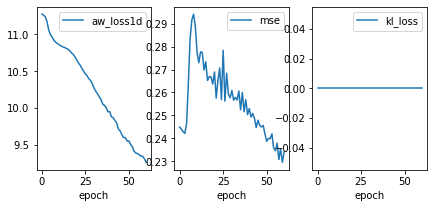

 61% (61 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:50
 62% (62 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:42
 63% (63 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:39
 64% (64 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:32
 65% (65 of 100) |##############         | Elapsed Time: 0:00:57 ETA:   0:00:29
 66% (66 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:27
 67% (67 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:33
 68% (68 of 100) |###############        | Elapsed Time: 0:01:00 ETA:   0:00:28
 69% (69 of 100) |###############        | Elapsed Time: 0:01:00 ETA:   0:00:24
 70% (70 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:24
 71% (71 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:32
 72% (72 of 100) |################       | Elapsed Time: 0:01:03 ETA:   0:00:27
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.2105872631072998, 'train_awi1d_loss': 8.90250301361084, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


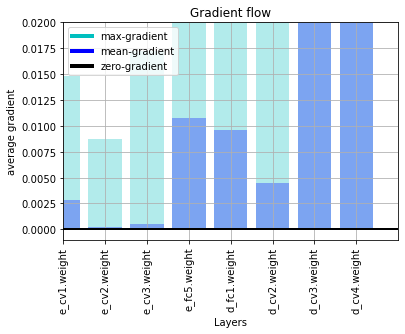

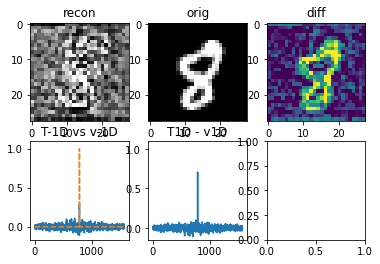

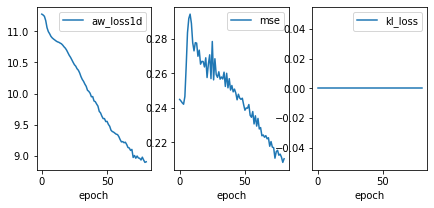

 81% (81 of 100) |##################     | Elapsed Time: 0:01:10 ETA:   0:00:15
 82% (82 of 100) |##################     | Elapsed Time: 0:01:11 ETA:   0:00:14
 83% (83 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:14
 84% (84 of 100) |###################    | Elapsed Time: 0:01:12 ETA:   0:00:13
 85% (85 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:10
 86% (86 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:09
 87% (87 of 100) |####################   | Elapsed Time: 0:01:14 ETA:   0:00:08
 88% (88 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:08
 89% (89 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:08
 90% (90 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:07
 91% (91 of 100) |####################   | Elapsed Time: 0:01:17 ETA:   0:00:07
 92% (92 of 100) |#####################  | Elapsed Time: 0:01:18 ETA:   0:00:05
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.1911146491765976, 'train_awi1d_loss': 8.525745391845703, 'train_kl_loss': 0.0}
 argidx T, v:  783 783


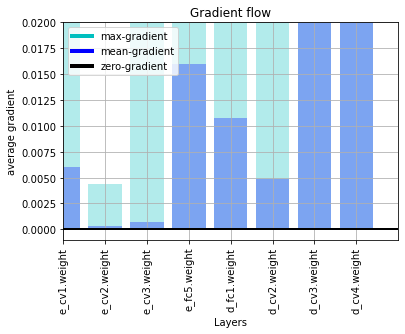

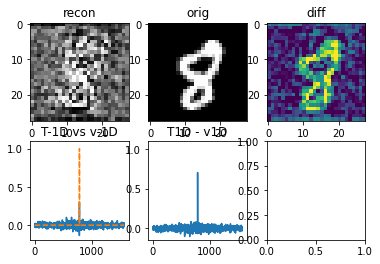

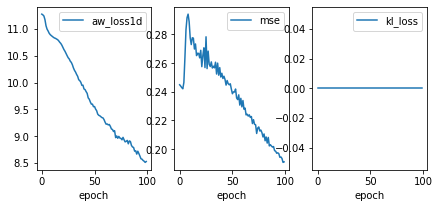

100% (100 of 100) |######################| Elapsed Time: 0:01:24 Time:  0:01:24


In [5]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23051676154136658, 'train_awi1d_loss': 22.583240509033203, 'train_kl_loss': 517.708984375}
 argidx T, v:  783 626


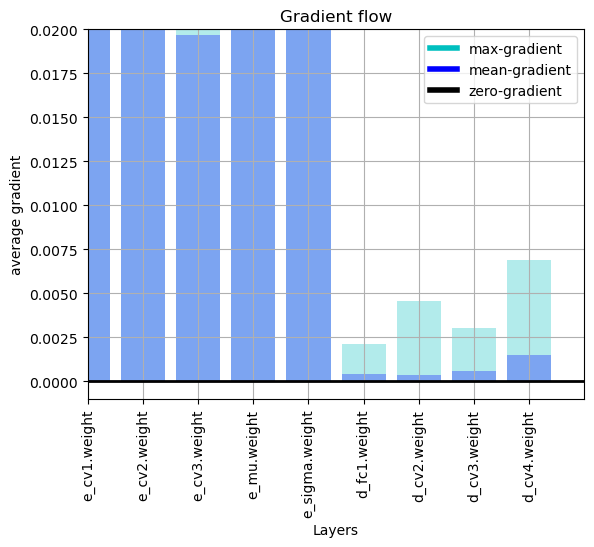

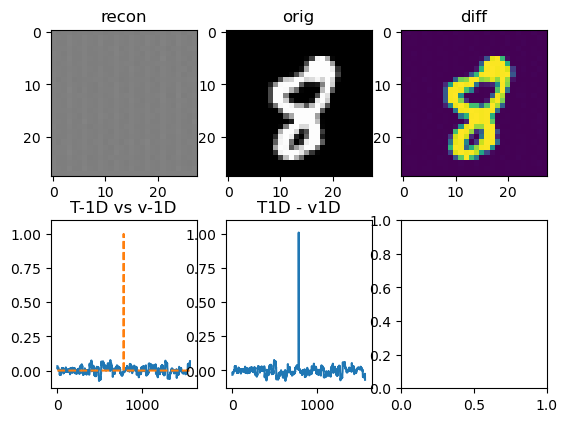

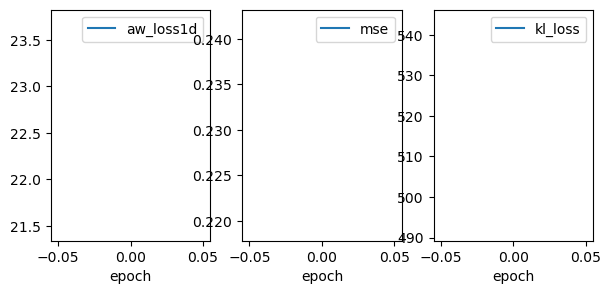

 20% (20 of 100) |####                   | Elapsed Time: 0:00:59 ETA:   0:03:56


 {'epoch': 20, 'train_mse': 0.2209753394126892, 'train_awi1d_loss': 22.082481384277344, 'train_kl_loss': 512.017333984375}
 argidx T, v:  783 528


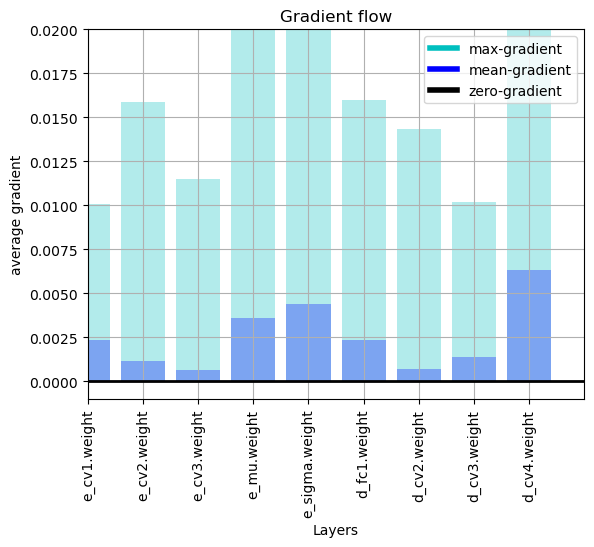

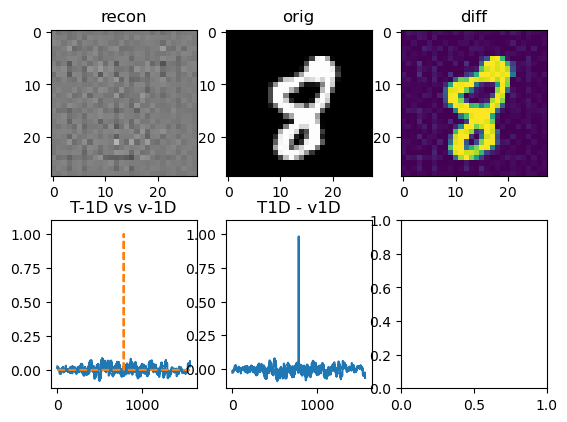

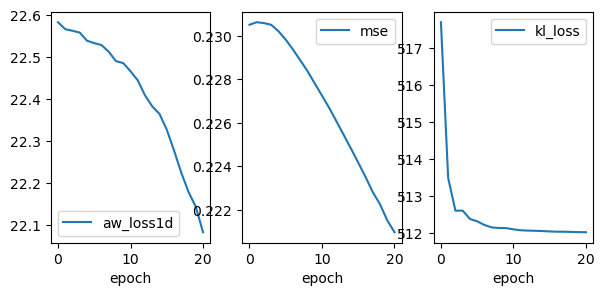

 40% (40 of 100) |#########              | Elapsed Time: 0:01:59 ETA:   0:02:52


 {'epoch': 40, 'train_mse': 0.2162109911441803, 'train_awi1d_loss': 21.386260986328125, 'train_kl_loss': 512.004150390625}
 argidx T, v:  783 950


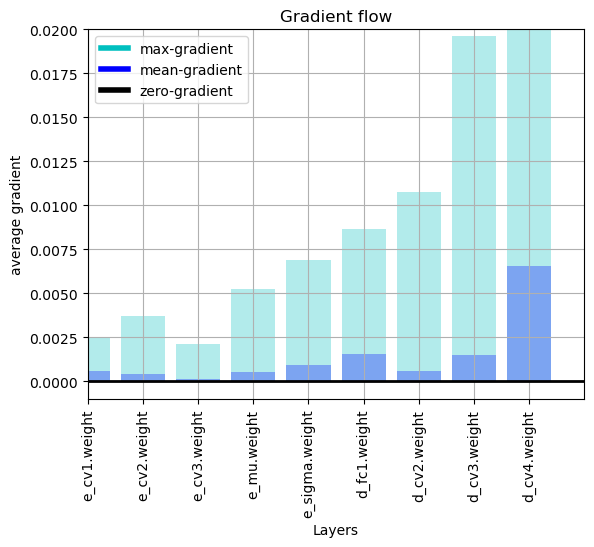

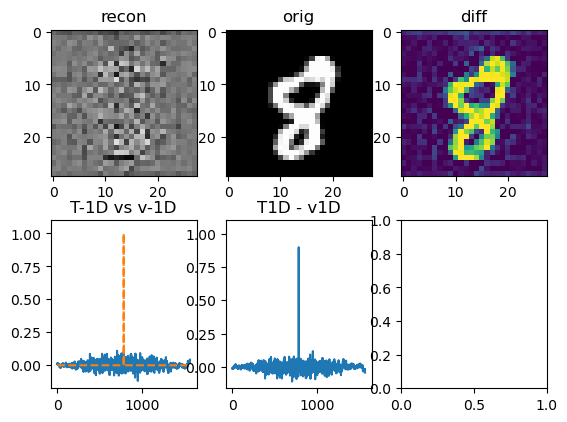

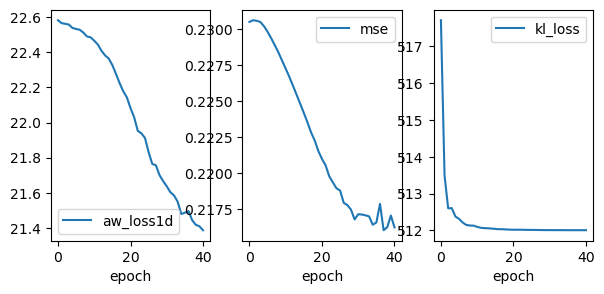

 60% (60 of 100) |#############          | Elapsed Time: 0:02:58 ETA:   0:01:56


 {'epoch': 60, 'train_mse': 0.2127932906150818, 'train_awi1d_loss': 21.164825439453125, 'train_kl_loss': 512.0020751953125}
 argidx T, v:  783 783


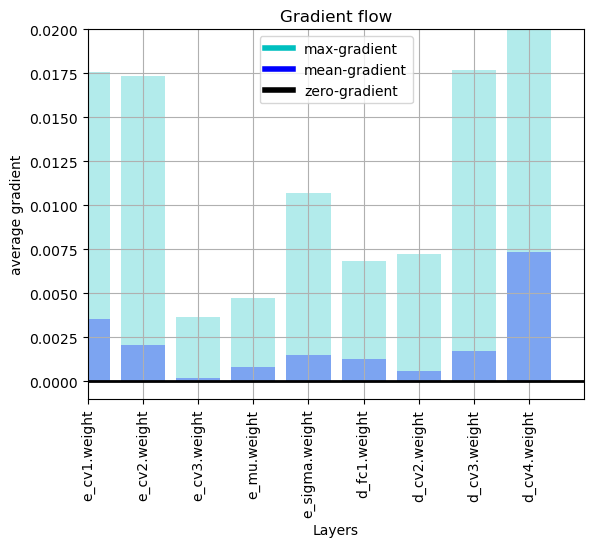

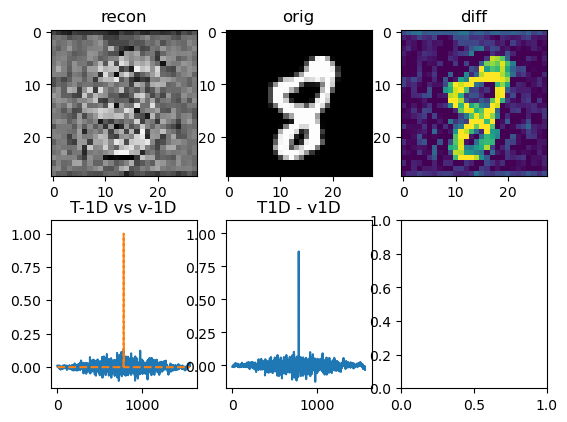

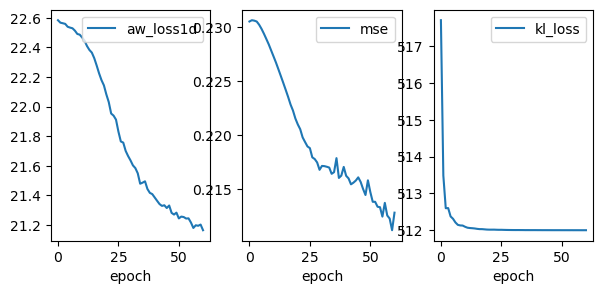

 80% (80 of 100) |##################     | Elapsed Time: 0:03:57 ETA:   0:00:57


 {'epoch': 80, 'train_mse': 0.19917955994606018, 'train_awi1d_loss': 21.057212829589844, 'train_kl_loss': 512.001220703125}
 argidx T, v:  783 783


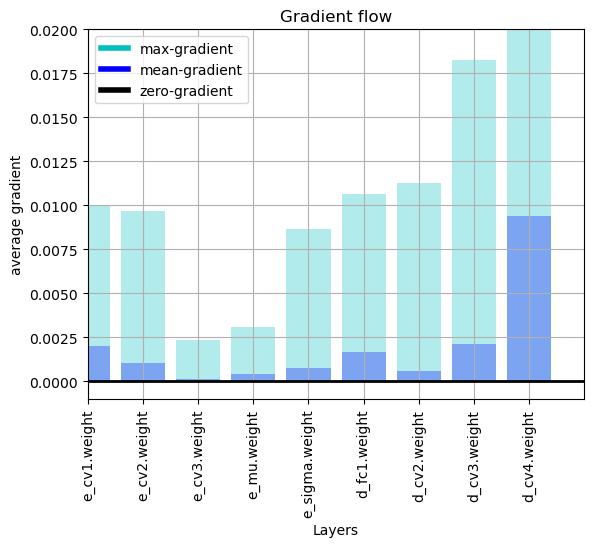

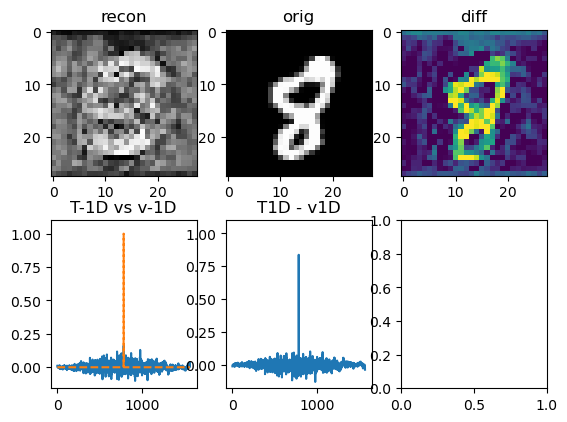

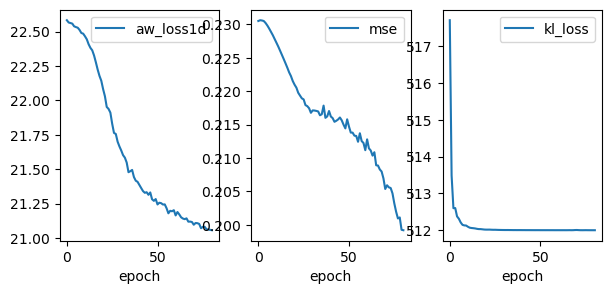

 99% (99 of 100) |###################### | Elapsed Time: 0:04:53 ETA:   0:00:02


 {'epoch': 99, 'train_mse': 0.1809442788362503, 'train_awi1d_loss': 20.9285888671875, 'train_kl_loss': 512.0028686523438}
 argidx T, v:  783 783


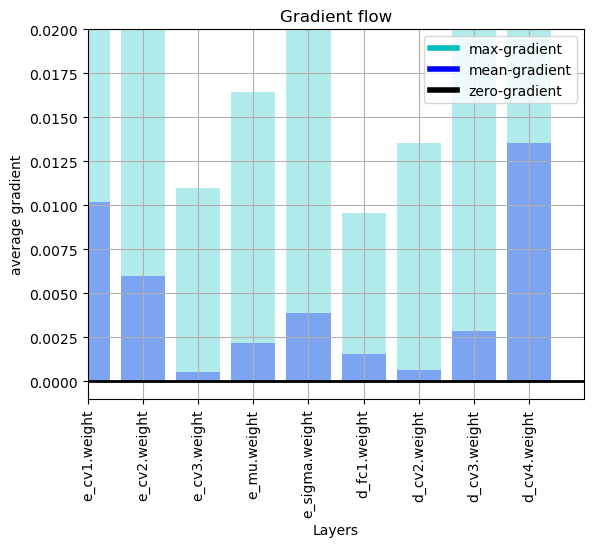

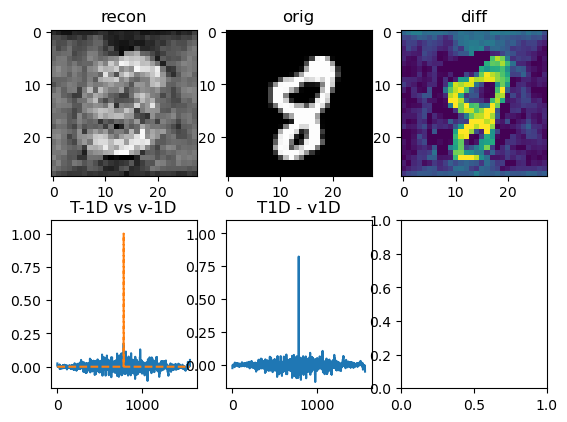

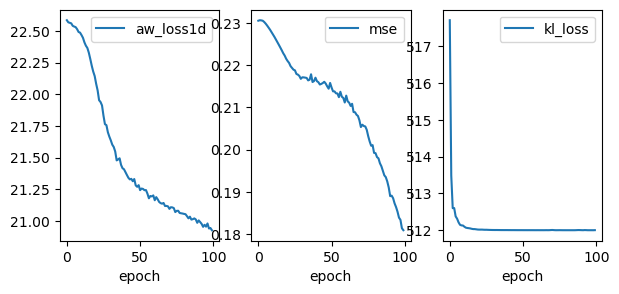

100% (100 of 100) |######################| Elapsed Time: 0:04:54 Time:  0:04:54


In [ ]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)